In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AdamW
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Dataset, DataLoader

# 訓練

In [ ]:
# 讀取你的航空服務數據集
file_path = '/content/drive/MyDrive/test/label/training_reviews.csv'  # 你的檔案路徑
data = pd.read_csv(file_path)

# 選取 'Sentence' 作為文本，1~11 欄位作為標籤
texts = data['Sentence'].astype(str)  # 確保是字串格式
labels = data.iloc[:, 6:].astype(float)  # 6列之後是標籤

# 初始化 tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization
tokens = texts.apply(lambda x: tokenizer.encode_plus(
    x, max_length=512, truncation=True, padding='max_length', return_tensors='pt'))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# 轉換成張量
input_ids = torch.cat([token['input_ids'] for token in tokens])
attention_masks = torch.cat([token['attention_mask'] for token in tokens])
labels = torch.tensor(labels.values, dtype=torch.float32)  # 確保標籤是 float32

# 切分訓練集與測試集
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.1, random_state=42)
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.1, random_state=42)

# 設定 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:

# 初始化 BERT 模型（多標籤分類）
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=11)  # 11 個標籤
model = BertForSequenceClassification(config).to(device)

# 設定 DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 4
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

# 設定優化器與損失函數（多標籤分類應用 BCEWithLogitsLoss）
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
criterion = torch.nn.BCEWithLogitsLoss()  # 適用於多標籤分類

# 訓練 BERT
epochs = 4
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        batch_input_ids, batch_input_mask, batch_labels = [b.to(device) for b in batch]
        model.zero_grad()

        outputs = model(batch_input_ids, attention_mask=batch_input_mask)
        logits = outputs.logits

        loss = criterion(logits, batch_labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1} Loss: {total_loss / len(train_dataloader)}')

# 儲存訓練後的模型
model.save_pretrained("/content/drive/MyDrive/bert_airline_model")
tokenizer.save_pretrained("/content/drive/MyDrive/bert_airline_model")
print("Model saved successfully!")


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 Loss: 0.231732550536243
Epoch 2 Loss: 0.0923364688239437
Epoch 3 Loss: 0.06689275344796254
Epoch 4 Loss: 0.05558294837149441
Model saved successfully!


In [ ]:
# 儲存訓練後的模型
model.save_pretrained("/content/drive/MyDrive/test/BERT/bert_airline_model")
tokenizer.save_pretrained("/content/drive/MyDrive/test/BERT/bert_airline_model")

('/content/drive/MyDrive/test/BERT/bert_airline_model/tokenizer_config.json',
 '/content/drive/MyDrive/test/BERT/bert_airline_model/special_tokens_map.json',
 '/content/drive/MyDrive/test/BERT/bert_airline_model/vocab.txt',
 '/content/drive/MyDrive/test/BERT/bert_airline_model/added_tokens.json')

#載入模型


In [ ]:

# 設定模型儲存的路徑（對應你保存的地方）
model_path = "/content/drive/MyDrive/test/BERT/bert_airline_model"

# 載入 tokenizer 和 model
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# 移動到 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 設定模型為 "評估模式"（避免計算梯度，減少記憶體使用）
model.eval()

print("Model loaded successfully!")


Model loaded successfully!


# 模型表現

 ## Accuracy & F1-score

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# 進入 evaluation 模式
model.eval()

# 預測結果 & 真實標籤
predictions, true_labels = [], []

for batch in val_dataloader:
    batch_input_ids, batch_input_mask, batch_labels = [b.to(device) for b in batch]

    with torch.no_grad():  # 禁止計算梯度（節省記憶體）
        outputs = model(batch_input_ids, attention_mask=batch_input_mask)
        logits = outputs.logits

    # 轉換為 numpy 陣列
    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.cpu().numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

# 轉換為 numpy 陣列
predictions = np.vstack(predictions)
true_labels = np.vstack(true_labels)

# 使用 Sigmoid 函數將 logits 轉為 0~1
from scipy.special import expit
predictions = expit(predictions)  # 相當於 `torch.sigmoid(logits)`

# 設定閾值（Threshold）來判斷是否為 1
threshold = 0.4
predictions = (predictions > threshold).astype(int)

# 計算 Accuracy, F1-score 和 Recall
accuracy = accuracy_score(true_labels.flatten(), predictions.flatten())
f1 = f1_score(true_labels, predictions, average="macro")  # macro: 平均多標籤 F1-score
recall = recall_score(true_labels, predictions, average="macro")  # 計算 macro 平均召回率

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall Score: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.9788
Recall Score: 0.5036
F1 Score: 0.5156


## 測試句子

In [ ]:
def predict(text, tokenizer, model, device):
    model.eval()
    tokens = tokenizer.encode_plus(text, max_length=512, truncation=True, padding='max_length', return_tensors='pt')
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs[0]
    predicted_labels = logits.squeeze().cpu().numpy()

    return predicted_labels

# Example usage
#text = "The cabin crew was very friendly and helpful."   #predicted = 10
text = "the flight is delayed" # 11
predicted_labels = predict(text, tokenizer, model, device)
print(predicted_labels)

[-5.0416675  -3.166102   -2.9686477  -3.620268   -5.941254   -3.5466568
 -1.7371849  -2.58268    -0.69124067 -3.9845145  -0.44716188]


##Confusion Matrix

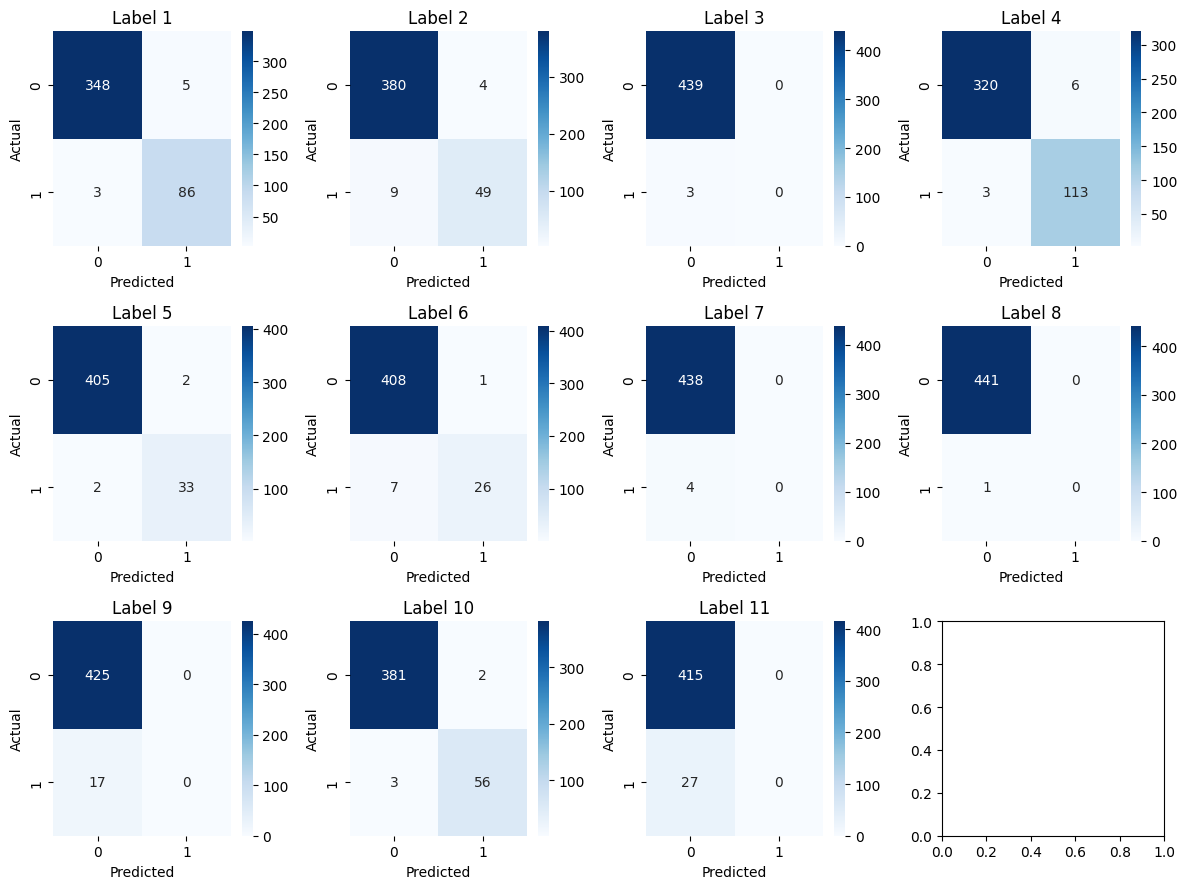

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# 計算 Confusion Matrix
conf_matrix = multilabel_confusion_matrix(true_labels, predictions)

# 可視化 Confusion Matrix（多標籤版）
fig, axes = plt.subplots(3, 4, figsize=(12, 9))  # 11 類別，排成 3x4 格
axes = axes.flatten()

for i in range(11):  # 你的分類數量
    sns.heatmap(conf_matrix[i], annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f'Label {i+1}')
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

1️⃣ 有些標籤（如 Label 3, 7, 8, 9, 11）完全沒有預測出 1（可能是因為這些標籤的數據量太少，模型學不出來）。

2️⃣ False Negative 比較多，代表模型對某些標籤的 召回率（Recall）較低，可能無法有效預測 少數標籤。